# 1. Setup

In [1]:
#@title Install required packages. { form-width: "320px" }
%pip install torch

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

%pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

#!pip install tensorboardX

1.11.0+cpu
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#@title Import dependencies { form-width: "320px" }
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#import torch_geometric
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import torch.nn as nn
import torch.nn.functional as F

# 2. Handling Plumbing Graphs
Let us define some functions to deal with plumbing graphs.

In [3]:
#@title A Function to create a graph from numpy dense arrays { form-width: "320px" }
def create_graph(x, a, y = None):
    # Create a graph as a `Data` object implemented in PyG (Pytorch Geometric) from node features `x` and
    # adjacency matrix `a`.
    # `x` and `a` are supposed to be dense numpy arrays.
    pyg_graph = Data()
    nx_graph = nx.from_numpy_matrix(a) # create a 'networkx' graph from a dense adjacency matrix 'a'
    pyg_graph = from_networkx(nx_graph) # convert a networkx graph into a pyg graph 
    pyg_graph.weight = None
    pyg_graph.x = torch.tensor(x.reshape(-1, 1), dtype = torch.float32) # feeding node features
    #pyg_graph.y = y # feeding labels
    return pyg_graph

In [4]:
#@title A Fuction for Neumann moves { form-width: "320px" }
def neumann_move(g_graph, neuman_move_type = np.random.randint(1,4)):
    # This function returns a graph obtained by applying a Neumann move to the input graph `g_graph`.
    # `g_graph` is an instance of `Data` object.
    # `neuman_move_type` denotes the type of Neumann move to be applied. Its values are integers from 1 to 3.
    # The default value of `neuman_move_type` is a random integer from 1 to 3.

    # Step 1: Get node features and adjacency matrix as numpy dense arrays.
    node_label = g_graph.x.numpy()
    node_label = node_label.flatten()
    #graph_y = g_graph.y
    n = len(node_label)
    if n == 1:
        adjacency = np.zeros((1,1))
    else:
        adjacency = to_dense_adj(g_graph.edge_index)
        adjacency = adjacency.numpy()[0, :, :]

    # Step 2: Randomly choose a vertex to which a Neumann move will be applied, and find vertices directly connected to
    #         the chosen vertex
    chosen_vertex = np.random.randint(0, n)
    linked_vs=[]
    for j in range(n):
        if adjacency[chosen_vertex, j] == 1:
            linked_vs = np.append(linked_vs, j)
    linked_vs = np.array(linked_vs, dtype=int)

    sign = 1 if np.random.random() < 0.5 else -1 # Sign for Neumann moves of types 1 and 2

    # If a graph consists of single vertex, then the available types of Neumann moves are 2 and 3.
    if len(linked_vs) == 0:
        neuman_move_type = 2 if np.random.random() < 0.5 else 3
    
    # Step 3: Apply Neumann moves to the chosen vertex
    if neuman_move_type == 1:
        chosen_linked_vertex = linked_vs[np.random.randint(0, len(linked_vs))]
        node_label = np.append(node_label, sign)
        node_label[chosen_vertex] = node_label[chosen_vertex] + sign
        node_label[chosen_linked_vertex] = node_label[chosen_linked_vertex] + sign
        adjacency = np.append(adjacency, np.zeros((n, 1)), axis = 1)
        adjacency[chosen_vertex, n] = adjacency[chosen_linked_vertex, n ] = 1
        adjacency = np.append(adjacency, np.zeros((1, n + 1)), axis = 0)
        adjacency[n, chosen_vertex] = adjacency[n, chosen_linked_vertex] = 1
        adjacency[chosen_vertex, chosen_linked_vertex] = adjacency[chosen_linked_vertex, chosen_vertex] = 0
    elif neuman_move_type == 2:
        node_label = np.append(node_label, sign)
        node_label[chosen_vertex] = node_label[chosen_vertex] + sign
        adjacency = np.append(adjacency, np.zeros((n, 1)), axis = 1)
        adjacency[chosen_vertex, n] = 1
        adjacency = np.append(adjacency, np.zeros((1, n + 1)), axis = 0)
        adjacency[n, chosen_vertex] = 1        
    elif neuman_move_type == 3:
        node_label = np.append(node_label, 0)
        node_diff = np.random.randint(-20, 20)
        node_label = np.append(node_label, node_diff)
        node_label[chosen_vertex] = node_label[chosen_vertex] - node_diff
        adjacency = np.append(adjacency, np.zeros((n, 1)), axis = 1)
        adjacency = np.append(adjacency, np.zeros((1, n + 1)), axis = 0)
        adjacency = np.append(adjacency, np.zeros((n + 1, 1)), axis = 1)
        adjacency = np.append(adjacency, np.zeros((1, n + 2)), axis = 0)
        adjacency[chosen_vertex, n] = adjacency[n, chosen_vertex] = 1
        adjacency[n, n + 1] = adjacency[n + 1, n] = 1
        if len(linked_vs) > 0:
            np.random.shuffle(linked_vs)
            n_split = np.random.randint(0, len(linked_vs))
            if n_split != 0 or n_split != len(linked_vs)-1:
                linked_chosen_2 = linked_vs[n_split:]
                for i in linked_chosen_2:
                    adjacency[chosen_vertex, i] = adjacency[i, chosen_vertex] = 0
                    adjacency[n + 1, i] = adjacency[i, n + 1] = 1
    # Output
    node_label = node_label.reshape(-1, 1)
    return create_graph(node_label, adjacency)

In [5]:
#@title A Function to Plot a Graph { form-width: "320px" }
def plot_graph(pyg_graph):
    # First convert a PyG graph to a `networkx` graph, then plot the graph by using `nx.draw` function.
    # Config 
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    g = to_networkx(pyg_graph, to_undirected=True) #convert to networkx graph

    labeldict = {} # node labels in the plot
    for i in range(pyg_graph.num_nodes):
        labeldict[i]=pyg_graph.x[i].item()
    # Plot
    pos_nodes = nx.kamada_kawai_layout(g)
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
    nx.draw(g, pos_nodes, node_color='black', node_size=30)
    nx.draw_networkx_labels(g, pos_attrs, labels=labeldict)
    plt.show()

In [6]:
#@title Creating a random Graph { form-width: "320px" }
def random_graph():
    # Returns a random graph (plumbing TREE) as an instance of `Data` object of PyG.
    # `n` : number of nodes, a random integer from 1 to 14
    # `x` : node features, an numpy array of random integers from -10 to 9
    # `a` : adjacency matrix
    n = np.random.randint(1, 15)
    x = np.random.randint(-10, 10, size = n)
    a=np.zeros((n, n))
    for i in range(1,n):
        j=np.random.randint(i)
        a[i,j]=a[j,i]=1
    return create_graph(x, a)

As an example, we are trying to create a random graph by using `random_graph()` function and plot it by the function named `plot_graph()`.

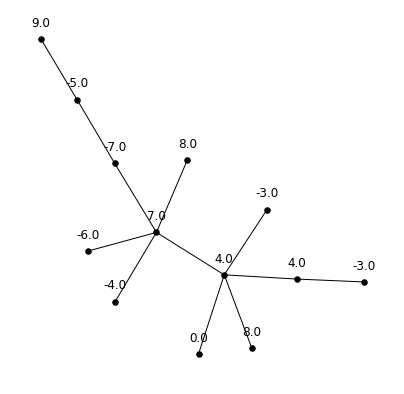


Type of Node Features:            torch.Size([13, 1])
Number of nodes:                  13
Weights of vertices:              [ 4.  7.  4.  8. -7. -5.  9. -6. -4.  0. -3.  8. -3.]
Number of edges:                  12.0



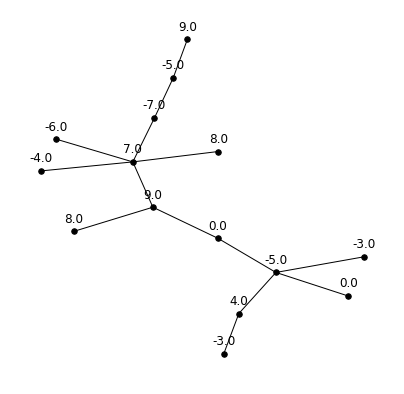


Number of nodes:                  15
Weights of vertices:              [-5.  7.  4.  8. -7. -5.  9. -6. -4.  0. -3.  8. -3.  0.  9.]
Number of edges:                  14.0



In [7]:
#@title An Example { form-width: "320px" }
g_graph = random_graph()
plot_graph(g_graph)
print()
print(f'Type of Node Features:            {g_graph.x.size()}')
print(f'Number of nodes:                  {g_graph.num_nodes}')
print(f'Weights of vertices:              {g_graph.x[:, 0].numpy()}')
print(f'Number of edges:                  {g_graph.num_edges/2}')
print()
g1_graph = neumann_move(g_graph)
plot_graph(g1_graph)
print()
print(f'Number of nodes:                  {g1_graph.num_nodes}')
print(f'Weights of vertices:              {g1_graph.x[:, 0].numpy()}')
print(f'Number of edges:                  {g1_graph.num_edges/2}')
print()

# 3. Preparing Datasets

In [8]:
#@title Defining PairData as a subclass of Data for storing two graphs { form-width: "320px" }
class PairData(Data):
    def __init__(self, edge_index_s=None, x_s=None, edge_index_t=None, x_t=None, y = None):
        super().__init__()
        self.edge_index_s = edge_index_s
        self.x_s = x_s
        self.edge_index_t = edge_index_t
        self.x_t = x_t
        self.y = y
        
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index_s':
            return self.x_s.size(0)
        if key == 'edge_index_t':
            return self.x_t.size(0)
        else:
            return super().__inc__(key, value, *args, **kwargs)

In [9]:
#@title Generate a random dataset { form-width: "320px" }
def generate_dataset(n_pairs = 50, n_moves = 11):
    data_list = []
    
    for j in range(0, n_pairs):
      pos = 1 if np.random.random() < 0.5 else -1
      g1 = random_graph()
      #for i in range(np.random.randint(1,n_moves)):
      #  g1 = neumann_move(g1)
      if pos == 1:
        g2 = g1
        for i in range(np.random.randint(1, n_moves)):
          g1 = neumann_move(g1)
        for i in range(np.random.randint(1, n_moves)):
          g2 = neumann_move(g2)
      else:
        g2 = random_graph()
        for i in range(np.random.randint(1, n_moves)):
          g1 = neumann_move(g1)
        for i in range(np.random.randint(1, n_moves)):
          g2 = neumann_move(g2)
      #y = torch.tensor([pos]).unsqueeze(1)
      if pos == 1:
        y = torch.tensor([pos])
      else:
        y = torch.tensor([0])
      
      # Normalize
      #g1.x = F.normalize(g1.x, p = 2, dim = 0)
      #lg2.x = F.normalize(g2.x, p = 2, dim = 0)

      # Save
      data_list.append(PairData(edge_index_s = g1.edge_index, x_s = g1.x, 
                                edge_index_t = g2.edge_index, x_t = g2.x, y = y))
    return data_list

In [10]:
#@title Create Sets for training and testing { form-width: "320px" }
dataset = generate_dataset(n_pairs = 1200, n_moves = 6)
data_size = len(dataset)
train_loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=32, shuffle=False, follow_batch=['x_s', 'x_t'])
test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=32, shuffle=False, follow_batch=['x_s', 'x_t'])

# 4. Build a Model and Test

In [11]:
class NodeEncoder(nn.Module):
    def __init__(self, node_feat_dim, node_hidden_sizes):
        """Constructor.
        Args:
          node_hidden_sizes: if provided should be a list of ints, hidden sizes of
            node encoder network, the last element is the size of the node outputs.
            If not provided, node features will pass through as is.
        """
        super(NodeEncoder, self).__init__()
        self.node_feat_dim = node_feat_dim
        self.node_hidden_sizes = node_hidden_sizes
        self._build_model()
        
    def _build_model(self):
        layer = []
        layer.append(nn.Linear(self.node_feat_dim, self.node_hidden_sizes[0]))
        for i in range(1, len(self.node_hidden_sizes)):
            layer.append(nn.ReLU())
            layer.append(nn.Linear(self.node_hidden_sizes[i - 1], self.node_hidden_sizes[i]))
        self.mlp_encoder = nn.Sequential(*layer)
        
    def forward(self, node_features):
        """Encode node features.
        Args:
          node_features: [n_nodes, node_feat_dim] float tensor.          
        Returns:
          node_outputs: [n_nodes, node_embedding_dim] float tensor, node embeddings.
        """
        if self.node_hidden_sizes is None:
            node_outputs = node_features
        else:
            node_outputs = self.mlp_encoder(node_features)
        
        return node_outputs        

In [12]:
from torch_geometric.nn import MessagePassing, MLP
class GMatchLayer(MessagePassing):
    def __init__(self, in_chs, hid_chs, out_chs):
        super().__init__(aggr='add')  # "Add" aggregation.
        self.in_chs = in_chs
        self.hid_chs = hid_chs
        self.out_chs = out_chs
        self._build_model()
        
    def _build_model(self):
        layer = []
        layer.append(nn.Linear(self.in_chs, self.hid_chs))
        layer.append(nn.ReLU())
        layer.append(nn.Linear(self.hid_chs, self.out_chs))
        self.mlp_node = nn.Sequential(*layer)

        layer = []
        layer.append(nn.Linear(2 * self.out_chs, self.hid_chs))
        layer.append(nn.ReLU())
        layer.append(nn.Linear(self.hid_chs, self.out_chs))
        self.mlp_msg = nn.Sequential(*layer)
           
    def forward(self, x, edge_index):
        x_changed = self.mlp_node(x)
        return self.propagate(edge_index, x = x_changed)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim = 1)
        
        return self.mlp_msg(tmp)
    
    def update(self, aggr_out):
        
        return aggr_out

In [13]:
def pairwise_cosine_similarity(a, b):
    """Compute the cosine similarity between x and y.
    This function computes the following similarity value between each pair of x_i
    and y_j: s(x_i, y_j) = x_i^T y_j / (|x_i||y_j|).
    Args:
      x: NxD float tensor.
      y: MxD float tensor.
    Returns:
      s: NxM float tensor, the pairwise cosine similarity.
    """

    a_norm = torch.norm(a, dim = 1).unsqueeze(-1)
    b_norm = torch.norm(b, dim = 1).unsqueeze(-1)
    
    return torch.matmul(a_norm, b_norm.T)

In [15]:
class GraphMatchingLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphMatchingLayer, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self._build_model()
        
    def _build_model(self):
        self.GMsgPass = GMatchLayer(in_chs = self.in_channels, hid_chs = self.hidden_channels, out_chs = self.out_channels)
        
        layer = []
        layer.append(nn.Linear(self.out_channels + 2 * self.in_channels, self.hidden_channels))
        layer.append(nn.ReLU())
        layer.append(nn.Linear(self.hidden_channels, self.out_channels))
        self.mlp_upd = nn.Sequential(*layer)
        
    def forward(self, x_s, x_t, data):
        
        edge_index_s, edge_index_t = data.edge_index_s, data.edge_index_t
        x_s_batch, x_t_batch = data.x_s_batch, data.x_t_batch
        x_s_msg = self.GMsgPass(x_s, edge_index_s)
        x_t_msg = self.GMsgPass(x_t, edge_index_t)
        
        n_graphs = data.y.size(0)
        
        x_s_mu = torch.zeros(x_s.size())
        x_t_mu = torch.zeros(x_t.size())
        
        for k in range(0, n_graphs):
            x = x_s[torch.where(x_s_batch == k)]
            y = x_t[torch.where(x_t_batch == k)]
            a = pairwise_cosine_similarity(x, y)
            a_i = F.softmax(a, dim=1)
            a_j = F.softmax(a, dim=0)
            att_i = torch.matmul(a_i, y)
            att_j = torch.matmul(a_j.T, x)
            x = x - att_i
            y = y - att_j
            x_s_mu[torch.where(x_s_batch == k)] = x
            x_t_mu[torch.where(x_t_batch == k)] = y
            
        result_s = self.mlp_upd(torch.cat([x_s, x_s_msg, x_s_mu], dim = 1))
        result_t = self.mlp_upd(torch.cat([x_t, x_t_msg, x_t_mu], dim = 1))
        
        return result_s, result_t

In [16]:
from torch_scatter import scatter_mean
class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_msgpass = 5):
        super(GraphAggregator, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.num_msgpass = num_msgpass
        self._build_model()
            
    def _build_model(self):
        layer = []
        layer.append(nn.Linear(self.in_channels, self.hidden_channels))
        layer.append(nn.ReLU())
        layer.append(nn.Linear(self.hidden_channels, self.out_channels))
        self.mlp = nn.Sequential(*layer)
        
        layer = []
        layer.append(nn.Linear(self.in_channels, self.hidden_channels))
        layer.append(nn.ReLU())
        layer.append(nn.Linear(self.hidden_channels, self.out_channels))
        self.mlp_gate = nn.Sequential(*layer)
        
        layer = []
        layer.append(nn.Linear(self.out_channels, self.hidden_channels))
        layer.append(nn.ReLU())
        layer.append(nn.Linear(self.hidden_channels, self.out_channels))
        self.mlp_final = nn.Sequential(*layer)
        
            
    def forward(self, x):
        # print("x:", x.shape)
        x_states = self.mlp(x)
        x_gates = F.softmax(self.mlp_gate(x), dim = 1)
        x_states = x_states * x_gates
        
        # print("x_states:", x_states.shape)
        # print("batch:", batch.shape)
        #x_states = scatter_mean(x_states, x_batch, dim = 0)
        x_states = self.mlp_final(x_states)
        return x_states

In [17]:
class GraphMatchingNet(torch.nn.Module):
	def __init__(self, num_msgpss = 5):
		super(GraphMatchingNet, self).__init__()
		self.num_msgpss = num_msgpss
		self.layers = torch.nn.ModuleList()
		self.layers.append(GraphMatchingLayer(in_channels = 1, hidden_channels = 32, out_channels = 16))
		for _ in range(self.num_msgpss - 1):
			self.layers.append(GraphMatchingLayer(in_channels = 16, hidden_channels = 32, out_channels = 16))
		self.aggregator = GraphAggregator(in_channels = 16, hidden_channels = 32, out_channels= 16)
		self.classification = MLP(in_channels = 32, hidden_channels = 32, out_channels = 2, num_layers = 3)

	
	def compute_embedding(self, data):
		x_s, x_t = data.x_s, data.x_t
		for i in range(self.num_msgpss):
			x_s, x_t = self.layers[i](x_s, x_t, data)
		x_s = self.aggregator(x_s)
		x_t = self.aggregator(x_t)
		x_s = scatter_mean(x_s, data.x_s_batch, dim = 0)
		x_t = scatter_mean(x_t, data.x_t_batch, dim = 0)
		return x_s, x_t

	def forward(self, data):
		embed_s, embed_t = self.compute_embedding(data)
		out = torch.cat((embed_s, embed_t), 1)
		out = out.reshape(out.size(0), -1)
		out = self.classification(out)
		return out
model = GraphMatchingNet()
print(model)

GraphMatchingNet(
  (layers): ModuleList(
    (0): GraphMatchingLayer(
      (GMsgPass): GMatchLayer()
      (mlp_upd): Sequential(
        (0): Linear(in_features=18, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=16, bias=True)
      )
    )
    (1): GraphMatchingLayer(
      (GMsgPass): GMatchLayer()
      (mlp_upd): Sequential(
        (0): Linear(in_features=48, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=16, bias=True)
      )
    )
    (2): GraphMatchingLayer(
      (GMsgPass): GMatchLayer()
      (mlp_upd): Sequential(
        (0): Linear(in_features=48, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=16, bias=True)
      )
    )
    (3): GraphMatchingLayer(
      (GMsgPass): GMatchLayer()
      (mlp_upd): Sequential(
        (0): Linear(in_features=48, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_featu

In [18]:
#@title Train and Test Functions { form-width: "320px" }
def train():
    model.train()
    
    for data in train_loader:  # Iterate in batches over the training dataset.
         optimizer.zero_grad()
         x= model(data)  # Perform a single forward pass.
         loss = criterion(x, data.y)  # Compute the loss.
         
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         #optimizer.zero_grad()  # Clear gradients.

def test(loader):
  model.eval()
  correct = 0
  #loss = 0
  for data in loader:  # Iterate in batches over the training/test dataset.
      out = model(data)  
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred == data.y).sum())  # Check against ground-truth labels.
  return correct / len(loader.dataset)  # Derive ratio of correct predictions.

Results by Graph Matching Network
Epoch: 001, Train Acc: 0.5385, Test Acc: 0.4542
Epoch: 005, Train Acc: 0.5833, Test Acc: 0.5500
Epoch: 010, Train Acc: 0.7135, Test Acc: 0.6917
Epoch: 015, Train Acc: 0.7146, Test Acc: 0.6750
Epoch: 020, Train Acc: 0.7125, Test Acc: 0.6667
Epoch: 025, Train Acc: 0.7115, Test Acc: 0.6708
Epoch: 030, Train Acc: 0.7083, Test Acc: 0.6542
Epoch: 035, Train Acc: 0.7146, Test Acc: 0.6625
Epoch: 040, Train Acc: 0.7042, Test Acc: 0.6708
Epoch: 045, Train Acc: 0.7000, Test Acc: 0.6583
Epoch: 050, Train Acc: 0.7052, Test Acc: 0.6750
Epoch: 055, Train Acc: 0.7240, Test Acc: 0.6583
Epoch: 060, Train Acc: 0.7167, Test Acc: 0.6708
Epoch: 065, Train Acc: 0.7010, Test Acc: 0.6667
Epoch: 070, Train Acc: 0.7260, Test Acc: 0.7000
Epoch: 075, Train Acc: 0.7354, Test Acc: 0.7208
Epoch: 080, Train Acc: 0.7260, Test Acc: 0.6458
Epoch: 085, Train Acc: 0.7167, Test Acc: 0.6667
Epoch: 090, Train Acc: 0.7229, Test Acc: 0.6875
Epoch: 095, Train Acc: 0.7198, Test Acc: 0.7083
Epoch:

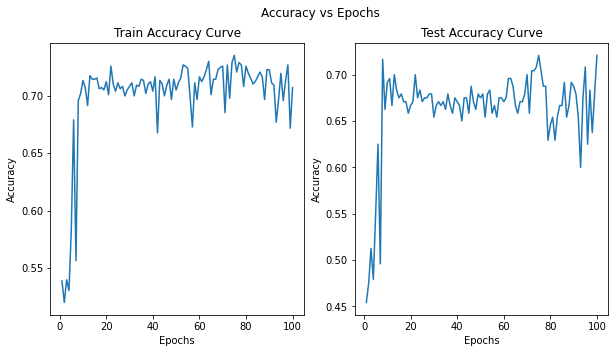

In [19]:
#@title Test Model-2 { form-width: "320px" }
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
train_acc = []
test_acc = []
print('Results by Graph Matching Network')
print('===========================================')
for epoch in range(1, 101):
    train()
    trainx = test(train_loader)
    testx = test(test_loader)
    train_acc.append(trainx)
    test_acc.append(testx)
    if epoch == 1 or epoch % 5 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {trainx:.4f}, Test Acc: {testx:.4f}')
print('===========================================')
print('Train Accuracy:')
print(f'    Minimum {np.min(train_acc) : .4f} \n    Maximum {np.max(train_acc) : .4f} ')
print('Test Accuracy:')
print(f'    Minimum {np.min(test_acc) : .4f} \n    Maximum {np.max(test_acc) : .4f} ')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Accuracy vs Epochs')

epoch = range(1, 101)
ax1.plot(epoch, train_acc)
ax1.set_xlabel('Epochs')  # Add an x-label to the axes.
ax1.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax1.set_title("Train Accuracy Curve")  # Add a title to the axes.

ax2.plot(epoch, test_acc)
ax2.set_xlabel('Epochs')  # Add an x-label to the axes.
ax2.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax2.set_title("Test Accuracy Curve")  # Add a title to the axes.
plt.show()

## Final Test

In [20]:
final_test_dataset = generate_dataset(n_pairs = 1000, n_moves = 11)
final_test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=True, follow_batch=['x_s', 'x_t'])

In [21]:
test(final_test_loader)

0.651